In [8]:
import pyro
import pyro.distributions as dist
import torch

In [46]:
# vanilla LDA, from the pyro tutorial (note fixed document length)

def model(data=None, args=None, batch_size=None):
    # Globals.
    with pyro.plate("topics", args['num_topics']):
        topic_weights = pyro.sample("topic_weights", dist.Gamma(1. / args['num_topics'], 1.))
        topic_words = pyro.sample("topic_words",
                                  dist.Dirichlet(torch.ones(args['num_words']) / args['num_words']))

    # Locals.
    with pyro.plate("documents", args['num_docs']) as ind:
        if data is not None:
            with pyro.util.ignore_jit_warnings():
                assert data.shape == (args['num_words_per_doc'], args['num_docs'])
            data = data[:, ind]
        doc_topics = pyro.sample("doc_topics", dist.Dirichlet(topic_weights))
        with pyro.plate("words", args['num_words_per_doc']):
            # The word_topics variable is marginalized out during inference,
            # achieved by specifying infer={"enumerate": "parallel"} and using
            # TraceEnum_ELBO for inference. Thus we can ignore this variable in
            # the guide.
            word_topics = pyro.sample("word_topics", dist.Categorical(doc_topics),
                                      infer={"enumerate": "parallel"})
            data = pyro.sample("doc_words", dist.Categorical(topic_words[word_topics]),
                               obs=data)

    return topic_weights, topic_words, data

In [42]:
topic_weights, topic_words, data = model(args={'num_topics': 5, 'num_docs': 100, 'num_words': 1000, 'num_words_per_doc': 64})

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set()

In [44]:
data.shape

torch.Size([64, 100])

<AxesSubplot:>

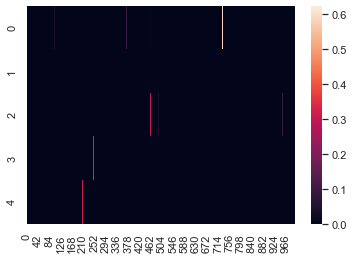

In [45]:
plt.figure()
sns.heatmap(topic_words)